<a href="https://colab.research.google.com/github/priyeshroy10155/Deep-learning-projects/blob/main/Cycle_GANs_CT_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#For downloding the dataset from google drive
#!gdown --folder https://drive.google.com/drive/folders/1c2JEoidK0OU1jVq5eeVqsJL4ZyHN4T7g?usp=sharing -O /content/drive/MyDrive/kaggledata_set/

In [3]:
import numpy as np
import pandas as pd
import os, math, sys
import time, datetime
import glob, itertools
import argparse, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.transforms import Resize

import plotly
from scipy import signal
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from torchsummary import summary

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [4]:
pretrained_model_path = "/content/drive/MyDrive/Cyclic_GANs/savemodels-20220927T031421Z-001/savemodels/saved_models"

In [5]:
dataset_path = "/content/drive/MyDrive/Cyclic_GANs"

In [6]:

# path to pre-trained models

# epoch to start training from
epoch_start = 25
# number of epochs of training
n_epochs = 150
# name of the dataset

# size of the batches"
batch_size = 3
# adam: learning rate
lr = 0.0001
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 1
# number of cpu threads to use during batch generation
n_workers = 8
# size of image height
img_height = 256
# size of image width
img_width = 256
# number of image channels
channels = 3
# interval between saving generator outputs
sample_interval = 100
# interval between saving model checkpoints
checkpoint_interval = -1
# number of residual blocks in generator
n_residual_blocks = 9
# cycle loss weight
lambda_cyc = 10.0
# identity loss weight
lambda_id = 5.0
# Development / Debug Mode
debug_mode = False

# Create images and checkpoint directories
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [7]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [8]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [9]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}A") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}B") + "/*.*"))
        if debug_mode:
            self.files_A = self.files_A[:100]
            self.files_B = self.files_B[:100]

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [10]:
# Image transformations
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
train_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=transforms_, unaligned=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_workers,
)
# Test data loader
test_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=1,
    shuffle=True,
    num_workers=1,
)

In [11]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)
        #print(summary(self.model, (3,256,256)))

    def forward(self, x):
        return self.model(x)
print('description of genaretor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
input_shape = (channels, img_height, img_width)
summary(GeneratorResNet(input_shape, n_residual_blocks).to(device),input_shape)

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2 ** 4 , width//2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

print('description of Discriminetor')
summary(Discriminator(input_shape).to(device),input_shape)
    


description of genaretor
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             R

In [12]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

cuda = torch.cuda.is_available()

input_shape = (channels, img_height, img_width)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

if epoch_start != 0:
    # Load pretrained models
    G_AB.load_state_dict(torch.load(f"{pretrained_model_path}/G_AB.pth"))
    G_BA.load_state_dict(torch.load(f"{pretrained_model_path}/G_BA.pth"))
    D_A.load_state_dict(torch.load(f"{pretrained_model_path}/D_A.pth"))
    D_B.load_state_dict(torch.load(f"{pretrained_model_path}/D_B.pth"))
else:
    # Initialize weights
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)



# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.load

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

train_counter = []
train_losses_gen, train_losses_id, train_losses_gan, train_losses_cyc = [], [], [], []
train_losses_disc, train_losses_disc_a, train_losses_disc_b = [], [], []

test_counter = [2*idx*len(train_dataloader.dataset) for idx in range(epoch_start+1, n_epochs+1)]
test_losses_gen, test_losses_disc = [], []


Training Epoch 25 :   0%|          | 0/10 [00:00<?, ?it/s]

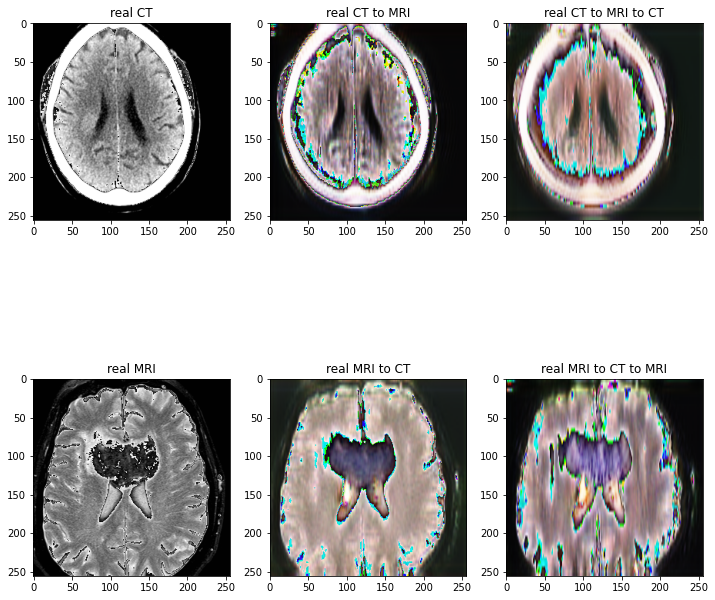

Training Epoch 26 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 27 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 28 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 29 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 30 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 31 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 32 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 33 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 34 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 35 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 36 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 37 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 38 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 39 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 40 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 41 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 42 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 43 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 44 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 45 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 46 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 47 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 48 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 49 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 50 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 51 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 52 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 53 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 54 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 55 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 56 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 57 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 58 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 59 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 60 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 61 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 62 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 63 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 64 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 65 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 66 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 67 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 68 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 69 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 70 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 71 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 72 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 73 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 74 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 75 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 76 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 77 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 78 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 79 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 80 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 81 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 82 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 83 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 84 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 85 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 86 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 87 :   0%|          | 0/10 [00:00<?, ?it/s]

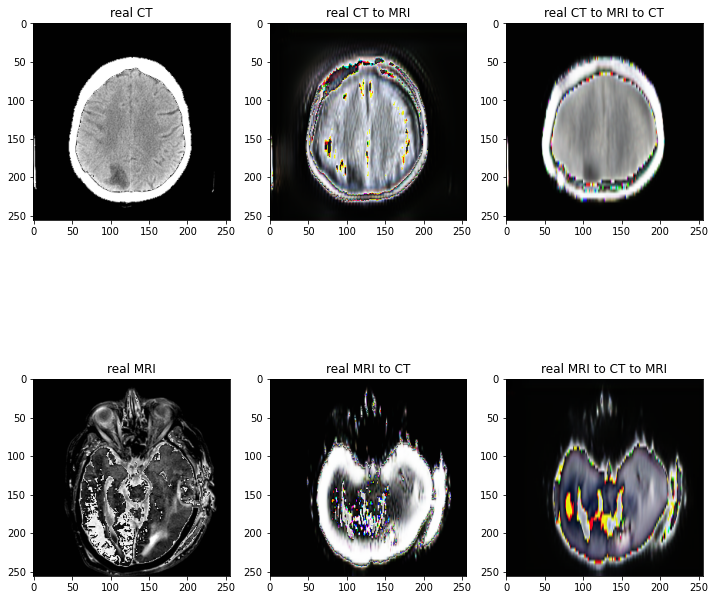

Training Epoch 88 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 89 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 90 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 91 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 92 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 93 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 94 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 95 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 96 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 97 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 98 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 99 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 100 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 101 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 102 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 103 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 104 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 105 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 106 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 107 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 108 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 109 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 110 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 111 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 112 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 113 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 114 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 115 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 116 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 117 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 118 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 119 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 120 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 121 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 122 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 123 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 124 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 125 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 126 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 127 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 128 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 129 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 130 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 131 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 132 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 133 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 134 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 135 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 136 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 137 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 138 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 139 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 140 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 141 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 142 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 143 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 144 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 145 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 146 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 147 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 148 :   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 149 :   0%|          | 0/10 [00:00<?, ?it/s]

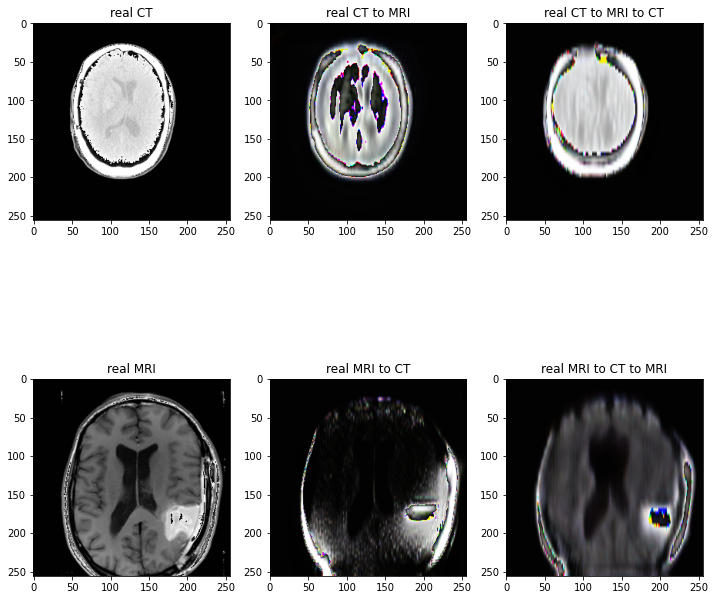

In [13]:
## for training

k=epoch_start

lis1,lis2,lis3,lis4,lis5,lis6,lis7=[],[],[],[],[],[],[]


for epoch in range(epoch_start, n_epochs):
    
    #### Training
    loss_gen = loss_id = loss_gan = loss_cyc = 0.0
    loss_disc = loss_disc_a = loss_disc_b = 0.0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    #print(len(train_dataloader))


    m=0
    
    for batch_idx, batch in enumerate(tqdm_bar):
       # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        #print(len(real_A))
        real_B = Variable(batch["B"].type(Tensor))
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        

       
          

        ### Train Generators
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        images=[]
        if m==0:
          if k==epoch_start or  k==n_epochs-1  or  k==(n_epochs+epoch_start)//2 :
             tran=transforms.ToPILImage()
             #print(real_A[0].shape)
             img=tran((real_A[0]))
             images.append(img)
            

             img=G_AB(real_A[0])
             resize = Resize((256,256))
             img1=resize(img)
             img2=tran(img1)
             #print("pic from train set A(MRI) after G_AB")
             #resize = Resize((256,256))
             #img1=resize(img1)
             images.append(img2)
            # plt.subplot(1,3,2)
             #plt.imshow(img2)
             #plt.show()

             img=tran((G_BA(img1)))
             #print("after G_BA CT img")  ###B_A
             resize = Resize((256,256))
             img=resize(img)
             images.append(img)
             #plt.subplot(1,3,3)
             #plt.imshow(img)
             #plt.show() 
             
             img=tran((real_B[0]))
             #print("pic from train set B==MRI")
             images.append(img)
             #plt.imshow(img)
             #plt.show()

             img=G_BA(real_B[0])
             resize = Resize((256,256))
             img3=resize(img)
             img=tran(img3)
             #print("pic from train set B(MRI) to CT after G_BA")
              #resize = Resize((256,256))
             # img=resize(img)
             images.append(img)
             #plt.imshow(img)
             #lt.show()

             img=tran(G_AB(img3))
             #print("pic from train set CT to  B(MRI) after G_AB")
             resize = Resize((256,256))
             img=resize(img)
             images.append(img)
             #plt.imshow(img)
             #plt.show() 


             fig=plt.figure(figsize=(12,12))
             
             for j in range(0,6):
               fig.add_subplot(2,3,j+1)
               plt.imshow(images[j])
               if j==0:
                 plt.title("real CT")
               elif j==1:
                 plt.title("real CT to MRI")
               elif j==2:
                 plt.title("real CT to MRI to CT")
               elif j==3:
                 plt.title("real MRI")
               elif j==4:
                 plt.title("real MRI to CT")
               else:
                 plt.title("real MRI to CT to MRI")

             plt.show()
   
          

        
        
             

         


        
        m=m+1
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total loss
        loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator-A
        D_A.train()
        optimizer_D_A.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        ### Train Discriminator-B
        D_B.train()
        optimizer_D_B.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
        loss_D = (loss_D_A + loss_D_B) / 2

        ### Log Progress
        loss_gen += loss_G.item(); loss_id += loss_identity.item(); loss_gan += loss_GAN.item(); loss_cyc += loss_cycle.item()
        loss_disc += loss_D.item(); loss_disc_a += loss_D_A.item(); loss_disc_b += loss_D_B.item()
        train_counter.append(2*(batch_idx*batch_size + real_A.size(0) + epoch*len(train_dataloader.dataset)))
        train_losses_gen.append(loss_G.item()); train_losses_id.append(loss_identity.item()); train_losses_gan.append(loss_GAN.item()); train_losses_cyc.append(loss_cycle.item())
        train_losses_disc.append(loss_D.item()); train_losses_disc_a.append(loss_D_A.item()); train_losses_disc_b.append(loss_D_B.item())
        tqdm_bar.set_postfix(Gen_loss=loss_gen/(batch_idx+1), identity=loss_id/(batch_idx+1), adv=loss_gan/(batch_idx+1), cycle=loss_cyc/(batch_idx+1),
                            Disc_loss=loss_disc/(batch_idx+1), disc_a=loss_disc_a/(batch_idx+1), disc_b=loss_disc_b/(batch_idx+1))

    
    lis1.append(loss_identity.item()),lis2.append(loss_GAN.item()),lis3.append(loss_cycle.item()),lis4.append(loss_G.item()),lis5.append(loss_D_A.item()),lis6.append(loss_D_B.item()),lis7.append(loss_D.item())
    # Save model checkpoints
    if np.argmin(train_losses_gen) == len(train_losses_gen)-1:
        # Save model checkpoints
        torch.save(G_AB.state_dict(), "saved_models/G_AB.pth")
        torch.save(G_BA.state_dict(), "saved_models/G_BA.pth")
        torch.save(D_A.state_dict(), "saved_models/D_A.pth")
        torch.save(D_B.state_dict(), "saved_models/D_B.pth")
        
        
    k+=1
    

  0%|          | 0/8 [00:00<?, ?it/s]

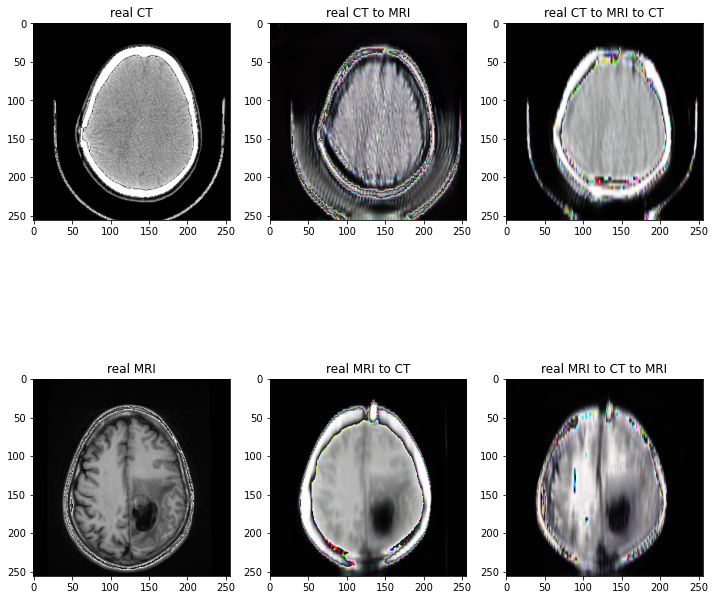

In [14]:
## Testing
loss_gen = loss_id = loss_gan = loss_cyc = 0.0
loss_disc = loss_disc_a = loss_disc_b = 0.0
tqdm_bar = tqdm(test_dataloader, total=int(len(test_dataloader)))
x=0
for batch_idx, batch in enumerate(tqdm_bar):

   # Set model input
        #print(batch_idx)
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        tran=transforms.ToPILImage()
       # print(real_A[0].shape)
       

        


        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        ### Test Generators
        G_AB.eval()
        G_BA.eval()
        images=[]
        if x==0:
          img=tran((real_A[0]))
         # print("pic from test set A==CT")
          images.append(img)
          #plt.imshow(img)
          #plt.show()
          
          img=(G_AB(real_A[0]))
          #print(G_AB(real_A[0]).shape)
          resize = Resize((256,256))
          img4=resize(img)
          img=tran(img4)
          images.append(img)
          #plt.imshow(img)
          #plt.show()

          img=tran(G_BA(img4))
          #print(G_AB(real_A[0]).shape)
          resize = Resize((256,256))
          img=resize(img)
          images.append(img)
          #plt.imshow(img)
          #plt.show()

          img=tran((real_B[0]))
          #print("pic from test set B==MRI")
          images.append(img)
          #plt.imshow(img)
          #plt.show()

          img=G_BA(real_B[0])
          resize = Resize((256,256))
          img5=resize(img)
          img=tran(img5)
          images.append(img)
          #plt.imshow(img)
          #plt.show()

          img=tran(G_AB(img5))
          resize = Resize((256,256))
          img=resize(img)
          images.append(img)
          #plt.imshow(img)
          #plt.show()

          
          fig=plt.figure(figsize=(12,12))
          for j in range(0,6):
              fig.add_subplot(2,3,j+1)
              plt.imshow(images[j])
              if j==0:
                plt.title("real CT")
              elif j==1:
                plt.title("real CT to MRI")
              elif j==2:
                plt.title("real CT to MRI to CT")
              elif j==3:
                plt.title("real MRI")
              elif j==4:
                plt.title("real MRI to CT")
              else:
                plt.title("real MRI to CT to MRI")

        plt.show()



        x=x+1
        


        

       


        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

        ### Test Discriminator-A
        D_A.eval()
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        ### Test Discriminator-B
        D_B.eval()
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D = (loss_D_A + loss_D_B) / 2
        
        ### Log Progress
        loss_gen += loss_G.item(); loss_id += loss_identity.item(); loss_gan += loss_GAN.item(); loss_cyc += loss_cycle.item()
        loss_disc += loss_D.item(); loss_disc_a += loss_D_A.item(); loss_disc_b += loss_D_B.item()
        tqdm_bar.set_postfix(Gen_loss=loss_gen/(batch_idx+1), identity=loss_id/(batch_idx+1), adv=loss_gan/(batch_idx+1), cycle=loss_cyc/(batch_idx+1),
                            Disc_loss=loss_disc/(batch_idx+1), disc_a=loss_disc_a/(batch_idx+1), disc_b=loss_disc_b/(batch_idx+1))
        list=[loss_identity.item(),loss_GAN.item(),loss_cycle.item(),loss_G.item(),loss_D_A.item(),loss_D_B.item(),loss_D.item()]
        # If at sample interval save image
        if random.uniform(0,1)<0.4:
            # Arrange images along x-axis
            real_A = make_grid(real_A, nrow=1, normalize=True)
            real_B = make_grid(real_B, nrow=1, normalize=True)
            fake_A = make_grid(fake_A, nrow=1, normalize=True)
            fake_B = make_grid(fake_B, nrow=1, normalize=True)
            # Arange images along y-axis
            image_grid = torch.cat((real_A, fake_B, real_B, fake_A), -1)
            save_image(image_grid, f"images/{batch_idx}.png", normalize=False)
        

   # test_losses_gen.append(loss_gen/len(test_dataloader))
   # test_losses_disc.append(loss_disc/len(test_dataloader))
  


       

       

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_losses_gen, mode='lines', name='Train Gen Loss (Loss_G)'))
fig.add_trace(go.Scatter(x=train_counter, y=train_losses_id, mode='lines', name='Train Gen Identity Loss'))
fig.add_trace(go.Scatter(x=train_counter, y=train_losses_gan, mode='lines', name='Train Gen GAN Loss'))
fig.add_trace(go.Scatter(x=train_counter, y=train_losses_cyc, mode='lines', name='Train Gen Cyclic Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_losses_gen, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Gen Loss (Loss_G)'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen (A+B)",
    yaxis_title="Generator Losses"),
plotly.offline.plot(fig, filename = 'plotly_gen_losses.html')
fig.show()

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_losses_disc, mode='lines', name='Train Disc Loss (Loss_D)'))
fig.add_trace(go.Scatter(x=train_counter, y=train_losses_disc_a, mode='lines', name='Train Disc-A Loss'))
fig.add_trace(go.Scatter(x=train_counter, y=train_losses_disc_b, mode='lines', name='Train Disc-B Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_losses_disc, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Disc Loss (Loss_G)'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen (A+B)",
    yaxis_title="Discriminator Losses"),
plotly.offline.plot(fig, filename = 'plotly_disc_losses.html')
fig.show()

In [17]:
Train_error_df=pd.DataFrame.from_dict(
    {
        'loss_identity':lis1,
        'loss_GAN':lis2,
        'loss_cycle':lis3,
         'loss_G':lis4,
         'loss_D_A':lis5,
        'loss_D_B':lis6,
        'loss_D':lis7,
         'epoch':[i for i in range( n_epochs-epoch_start)]
    }
).set_index('epoch')

In [18]:
Train_error_df  # Training loss in data frame

,loss_identity,loss_GAN,loss_cycle,loss_G,loss_D_A,loss_D_B,loss_D
epoch,,,,,,,
0,0.080149,0.573872,0.088210,1.856711,0.060361,0.120277,0.090319
1,0.092118,0.282008,0.101260,1.755196,0.106149,0.274471,0.190310
2,0.063142,0.275232,0.074839,1.339336,0.143637,0.152744,0.148190
3,0.099929,0.154941,0.104386,1.698446,0.116323,0.309298,0.212810
4,0.066900,0.589933,0.085098,1.775415,0.119498,0.141070,0.130284
...,...,...,...,...,...,...,...
120,0.030295,0.552567,0.050055,1.204594,0.087315,0.166278,0.126796
121,0.045339,0.671768,0.064738,1.545837,0.233873,0.154928,0.194401
122,0.029040,0.348885,0.052034,1.014425,0.143186,0.148506,0.145846


In [19]:
Train_error_df.describe()

,loss_identity,loss_GAN,loss_cycle,loss_G,loss_D_A,loss_D_B,loss_D
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,0.046454,0.539334,0.064097,1.412575,0.125862,0.152030,0.138946
std,0.013240,0.135532,0.011958,0.211573,0.050956,0.057483,0.042510
min,0.024823,0.154941,0.042076,0.994664,0.034677,0.034149,0.051456
25%,0.037011,0.453902,0.055807,1.276167,0.093812,0.107216,0.107502
50%,0.043243,0.544287,0.061907,1.385457,0.115797,0.144440,0.137820
75%,0.054303,0.613580,0.069790,1.520862,0.156773,0.185773,0.157064
max,0.099929,0.928949,0.104386,2.081589,0.312789,0.309298,0.283370


In [20]:
df_test=pd.DataFrame.from_dict(
    {
        'loss_identity':list[0],
        'loss_GAN':list[1],
        'loss_cycle':list[2],
         'loss_G':list[3],
         'loss_D_A':list[4],
        'loss_D_B':list[5],
        'loss_D':list[6],
         'error':['test_error']
    }
).set_index('error')

In [21]:
df_test

,loss_identity,loss_GAN,loss_cycle,loss_G,loss_D_A,loss_D_B,loss_D
error,,,,,,,
test_error,0.037507,0.606087,0.07034,1.497019,0.11076,0.217747,0.164254
